In [1]:

import sys
import os

repo_root = os.path.abspath(os.path.join(os.path.dirname(os.getcwd())))
sys.path.append(repo_root)

print(repo_root)

/home/jackyeung99/classes/proj_energy_volatility


In [2]:
import matplotlib.pyplot as plt
import math 
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from statsmodels.tsa.stattools import adfuller, coint
from arch import arch_model
from sklearn.linear_model import LinearRegression

from src.trading.IBKR_trading import TradingApp

In [3]:
plt.style.use("styler.mplstyle") 

## Feature Selection

In [4]:
def realized_vol(time_series, window: int = 21, annualize: bool = True) -> pd.DataFrame:
    """Compute rolling standard deviation of daily returns (realized volatility)."""
    
    volatility = time_series.rolling(window).std()
    
    if annualize:
        volatility *= np.sqrt(256)
    
    return np.log(volatility) 

def long_to_wide(df, pivot_by='close'):

    wide = df.pivot(index='date', columns='Symbol', values=pivot_by)
    wide = wide.reset_index()  
    wide.columns.name = None

    return wide

In [5]:
HOST = os.getenv("IB_HOST")
PORT = int(os.getenv("IB_PORT"))
CLIENT_ID = int(os.getenv("IB_CLIENT_ID"))

app = TradingApp()
await app.start(HOST, PORT, clientid=CLIENT_ID)

Connected to Interactive Brokers successfully.


In [6]:
macro = [
    'CPIAUCSL',   # CPI (All Urban Consumers)
    'INDPRO',     # Industrial Production Index
    'CNP16OV',    # Civilian Noninstitutional Population, 16+
    'FEDFUNDS',   # Effective Federal Funds Rate
    'VIXCLS',     # CBOE VIX Index (correct FRED ticker)
    'UNRATE'      # Unemployment Rate
]

In [7]:

fred = pdr.DataReader(
    macro,
    "fred",
    start="2015-07-01",
    end="2025-07-01"
).astype(float).reset_index()

fred['INF'] = 400 * np.log(fred['CPIAUCSL']/ fred['CPIAUCSL'].shift(1))

fred = fred.fillna(method = 'ffill')

/tmp/ipykernel_41141/4095544633.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fred = fred.fillna(method = 'ffill')


In [8]:
fred['INF'] = 400 * np.log(fred['CPIAUCSL']/ fred['CPIAUCSL'].shift(1))

In [9]:
fred = fred.fillna(method = 'ffill')

/tmp/ipykernel_41141/3427632824.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fred = fred.fillna(method = 'ffill')


In [10]:
fred

,DATE,CPIAUCSL,INDPRO,CNP16OV,FEDFUNDS,VIXCLS,UNRATE,INF
0,2015-07-01,238.034,101.0893,250876.0,0.13,16.09,5.2,NaN
1,2015-07-02,238.034,101.0893,250876.0,0.13,16.79,5.2,0.000000
2,2015-07-03,238.034,101.0893,250876.0,0.13,16.79,5.2,0.000000
3,2015-07-06,238.034,101.0893,250876.0,0.13,17.01,5.2,0.000000
4,2015-07-07,238.034,101.0893,250876.0,0.13,16.09,5.2,0.000000
...,...,...,...,...,...,...,...,...
2639,2025-06-25,321.500,104.2115,273585.0,4.33,16.76,4.1,0.000000
2640,2025-06-26,321.500,104.2115,273585.0,4.33,16.59,4.1,0.000000
2641,2025-06-27,321.500,104.2115,273585.0,4.33,16.32,4.1,0.000000
2642,2025-06-30,321.500,104.2115,273585.0,4.33,16.73,4.1,0.000000


In [11]:
stock_data = [
    'XLE',
    'SPY',
    # Crude Oil 
    ]

In [12]:
index_stock = await app.fetch_many_symbols(stock_data, '10 Y', '1 M', 'TRADES', rth=True)
stock = long_to_wide(index_stock).sort_values(by=['date'])

In [13]:
stock

,date,SPY,XLE
0,2015-11-30,208.69,68.02
1,2015-12-31,203.87,60.32
2,2016-01-29,193.72,58.21
3,2016-02-29,193.56,56.58
4,2016-03-31,205.52,61.89
...,...,...,...
116,2025-07-31,632.08,87.21
117,2025-08-29,645.05,90.39
118,2025-09-30,666.18,89.34
119,2025-10-31,682.06,88.13


In [14]:
stock['XLE_r'] = np.log(stock['XLE']).diff()

In [15]:
df = stock.merge(fred, left_on='date', right_on=['DATE'])

In [16]:
df

,date,SPY,XLE,XLE_r,DATE,CPIAUCSL,INDPRO,CNP16OV,FEDFUNDS,VIXCLS,UNRATE,INF
0,2015-11-30,208.69,68.02,NaN,2015-11-30,238.017,99.4366,251747.0,0.12,16.13,5.1,0.0
1,2015-12-31,203.87,60.32,-0.120138,2015-12-31,237.761,98.9471,251936.0,0.24,18.21,5.0,0.0
2,2016-01-29,193.72,58.21,-0.035607,2016-01-29,237.652,99.4391,252397.0,0.34,20.20,4.8,0.0
3,2016-02-29,193.56,56.58,-0.028402,2016-02-29,237.336,98.9232,252577.0,0.38,20.55,4.9,0.0
4,2016-03-31,205.52,61.89,0.089703,2016-03-31,238.080,98.1635,252768.0,0.36,13.95,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
111,2025-02-28,594.18,91.00,0.037622,2025-02-28,319.775,103.8705,272847.0,4.33,19.63,4.1,0.0
112,2025-03-31,559.39,93.45,0.026567,2025-03-31,319.615,103.5408,273023.0,4.33,22.28,4.2,0.0
113,2025-04-30,554.54,80.50,-0.149169,2025-04-30,320.321,103.6224,273197.0,4.33,24.70,4.2,0.0
114,2025-05-30,589.39,81.53,0.012714,2025-05-30,320.580,103.6570,273385.0,4.33,18.57,4.2,0.0


#### Macro Features

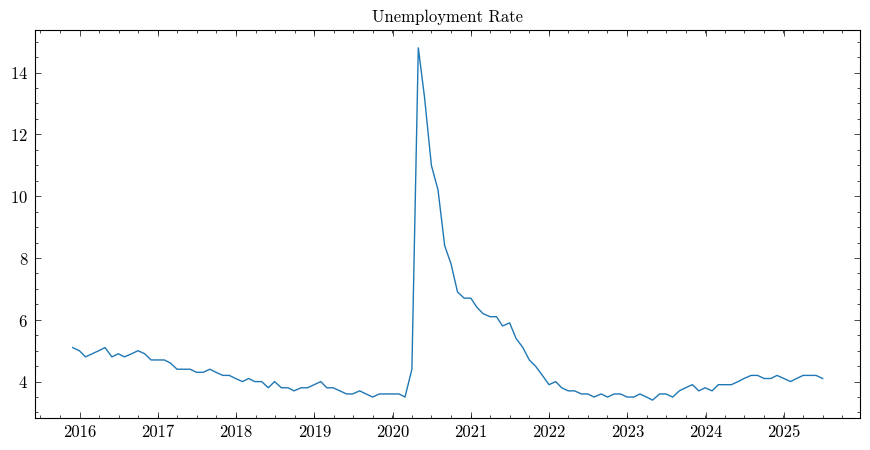

In [17]:
plt.figure(figsize=(10,5))
plt.title("Unemployment Rate")
plt.plot(df['date'], df['UNRATE'])

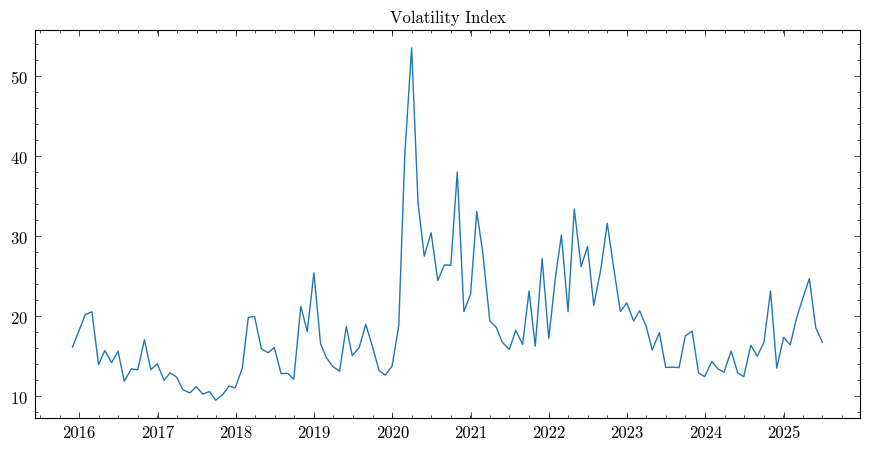

In [18]:
plt.figure(figsize=(10,5))
plt.title("Volatility Index")
plt.plot(df['date'], df['VIXCLS'])

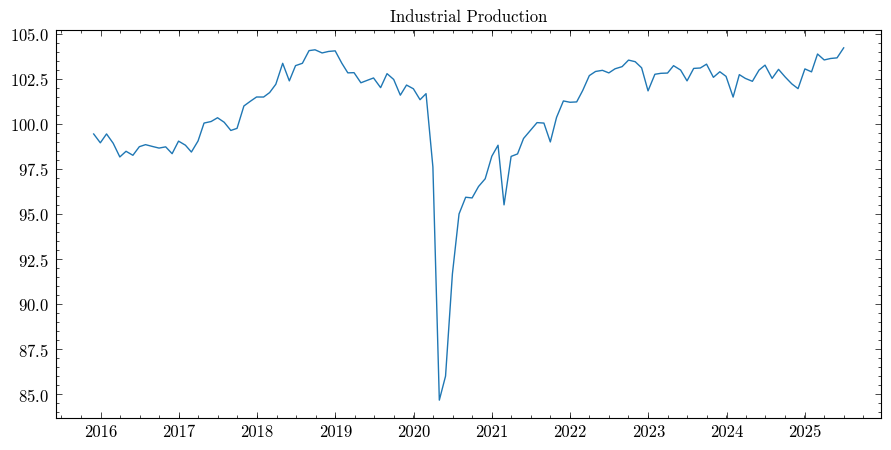

In [19]:
plt.figure(figsize=(10,5))
plt.title("Industrial Production")
plt.plot(df['date'], df['INDPRO'])

#### Stock and Indicators

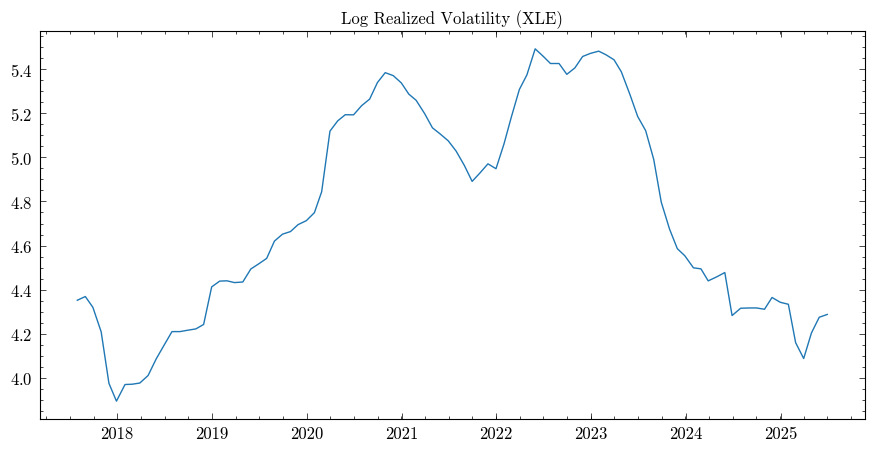

In [20]:
plt.figure(figsize=(10,5))
plt.title('Log Realized Volatility (XLE)')
plt.plot(df['date'], realized_vol(df['XLE']))

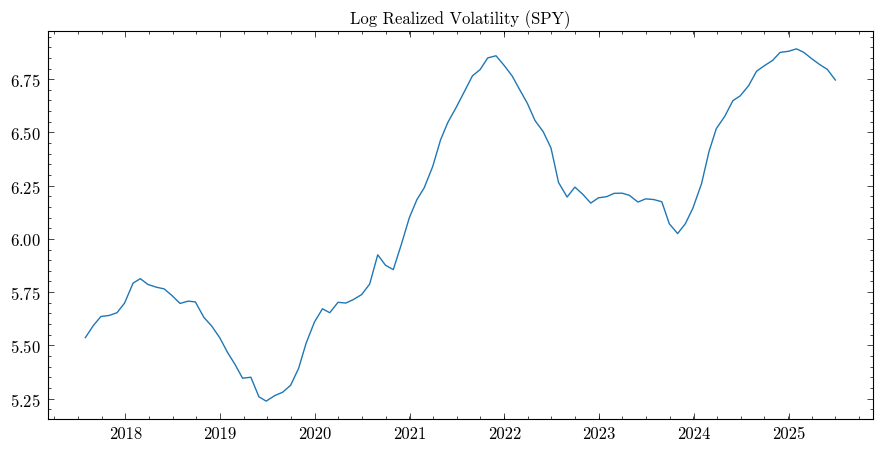

In [21]:
plt.figure(figsize=(10,5))
plt.title('Log Realized Volatility (SPY)')
plt.plot(df['date'], realized_vol(df['SPY']))

idiosyncratic volatility of XLE

In [22]:
df['XLE_log_realized_vol'] = realized_vol(df['XLE'])
df['SPY_log_realized_vol'] = realized_vol(df['SPY'])

In [23]:
df.dropna(subset=['XLE_log_realized_vol','SPY_log_realized_vol'], inplace=True)

In [24]:
X = df[['SPY_log_realized_vol']]   #
y = df['XLE_log_realized_vol']     

model = LinearRegression()
model.fit(X, y)


df['vol_unexplained'] = y - model.predict(X)

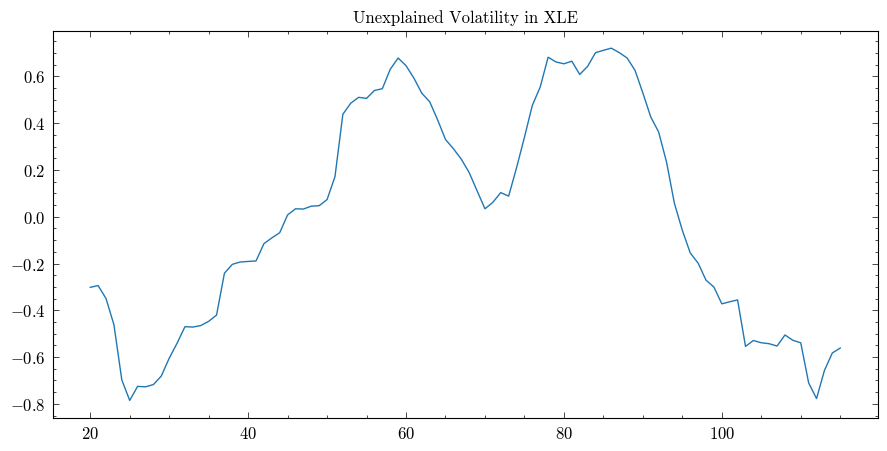

In [26]:
plt.figure(figsize=(10,5))
plt.title('Unexplained Volatility in XLE')
plt.plot(df['vol_unexplained'])

## GARCH

In [ ]:
df

,date,SPY,XLE,XLE_r,DATE,CPIAUCSL,INDPRO,CNP16OV,FEDFUNDS,VIXCLS,UNRATE,INF
0,2015-11-30,208.69,68.02,NaN,2015-11-30,238.017,99.4366,251747.0,0.12,16.13,5.1,0.0
1,2015-12-31,203.87,60.32,-0.120138,2015-12-31,237.761,98.9471,251936.0,0.24,18.21,5.0,0.0
2,2016-01-29,193.72,58.21,-0.035607,2016-01-29,237.652,99.4391,252397.0,0.34,20.20,4.8,0.0
3,2016-02-29,193.56,56.58,-0.028402,2016-02-29,237.336,98.9232,252577.0,0.38,20.55,4.9,0.0
4,2016-03-31,205.52,61.89,0.089703,2016-03-31,238.080,98.1635,252768.0,0.36,13.95,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
111,2025-02-28,594.18,91.00,0.037622,2025-02-28,319.775,103.8705,272847.0,4.33,19.63,4.1,0.0
112,2025-03-31,559.39,93.45,0.026567,2025-03-31,319.615,103.5408,273023.0,4.33,22.28,4.2,0.0
113,2025-04-30,554.54,80.50,-0.149169,2025-04-30,320.321,103.6224,273197.0,4.33,24.70,4.2,0.0
114,2025-05-30,589.39,81.53,0.012714,2025-05-30,320.580,103.6570,273385.0,4.33,18.57,4.2,0.0


In [29]:
y  = df['vol_unexplained']
X = df[['CPIAUCSL', 'INDPRO', 'CNP16OV', 'FEDFUNDS', 'VIXCLS', 'UNRATE']]

In [58]:
am = arch_model(
    y,
    mean='ARX',       # mean with exogenous regressors
    lags=0,           # 0 AR lags in the mean (you can set >0 if you want AR)
    x=X,              # exogenous variables in the mean
    vol='GARCH',      # GARCH volatility
    p=3, q=1,         # GARCH(1,1)
    dist='normal'     # or 't' if you want fat tails
)


In [59]:
res = am.fit(disp='off')

/tmp/ipykernel_41141/3265089574.py:1: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  res = am.fit(disp='off')


In [60]:
cond_vol = res.conditional_volatility
std_resid = res.std_resid


In [61]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          AR-X - GARCH Model Results                          
==============================================================================
Dep. Variable:        vol_unexplained   R-squared:                       0.266
Mean Model:                      AR-X   Adj. R-squared:                  0.217
Vol Model:                      GARCH   Log-Likelihood:               -29.1964
Distribution:                  Normal   AIC:                           82.3928
Method:            Maximum Likelihood   BIC:                           113.165
                                        No. Observations:                   96
Date:                Wed, Nov 12 2025   Df Residuals:                       89
Time:                        20:43:19   Df Model:                            7
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
Const          51.4083     11.392      4.513  6.397e-06       [ 29.081, 73.735]
CPIAUCSL        0.0593  1.190e-02      4.980  6.347e-07   [3.595e-02,8.260e-02]
INDPRO          0.0851      0.118      0.720      0.472       [ -0.147,  0.317]
CNP16OV    -2.9581e-04  5.295e-06    -55.861      0.000 [-3.062e-04,-2.854e-04]
FEDFUNDS       -0.0922      0.103     -0.899      0.369       [ -0.293,  0.109]
VIXCLS          0.0194  1.410e-02      1.373      0.170  [-8.274e-03,4.701e-02]
UNRATE          0.2187      0.229      0.956      0.339       [ -0.229,  0.667]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0260  5.258e-02      0.494      0.621 [-7.707e-02,  0.129]
alpha[1]       0.5002      1.276      0.392      0.695    [ -2.000,  3.001]
alpha[2]       0.1541      3.939  3.912e-02      0.969    [ -7.567,  7.875]
alpha[3]   3.5029e-03      1.365  2.567e-03      0.998    [ -2.671,  2.678]
beta[1]        0.0393      1.704  2.305e-02      0.982    [ -3.301,  3.380]
===========================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Iteration limit reached.
See convergence_flag.

"""

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df['DATE'], res.conditional_volatility)
plt.title("GARCH Conditional Volatility")
plt.xlabel("Time")
plt.ylabel("$\sigma^2$")
plt.show()

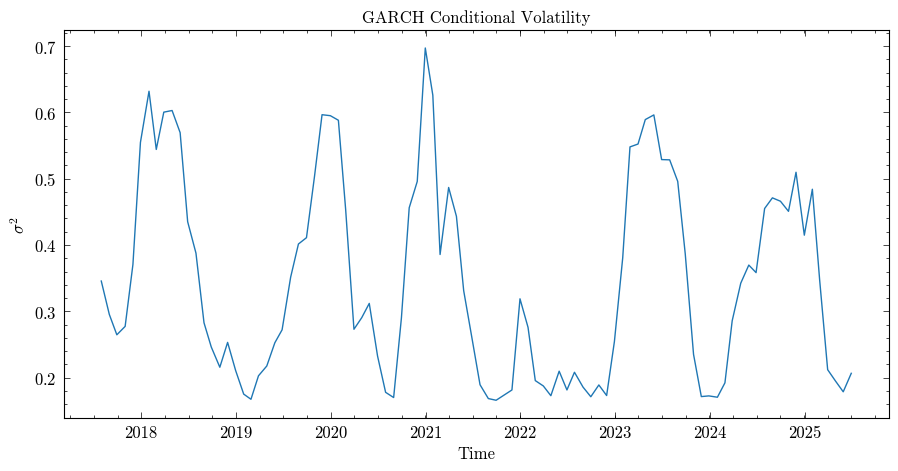

In [65]:

plt.figure(figsize=(10,5))
plt.plot(df['DATE'], res.conditional_volatility)
plt.title("GARCH Conditional Volatility")
plt.xlabel("Time")
plt.ylabel("$\sigma^2$")
plt.show()

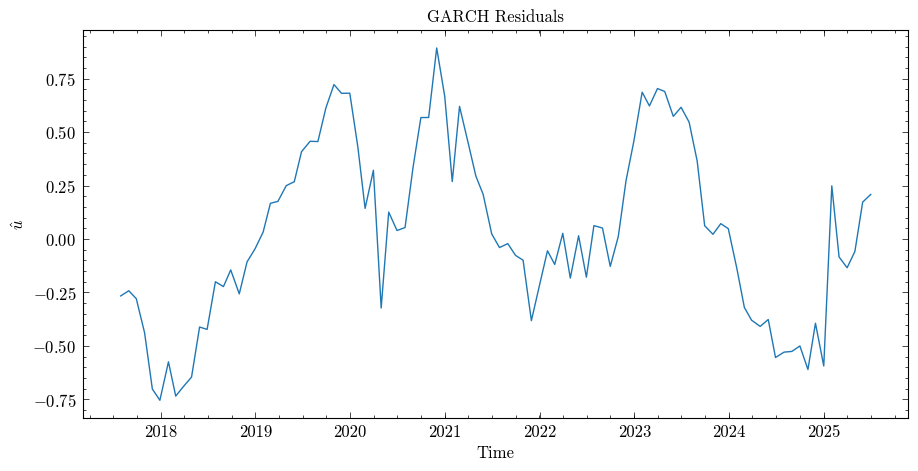

In [68]:

plt.figure(figsize=(10,5))
plt.plot(df['DATE'], res.resid)
plt.title("GARCH Residuals")
plt.xlabel("Time")
plt.ylabel("$\hat{u}$")
plt.show()